In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
% tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## 准备数据集

In [0]:
#加载文件路径
path_to_file='/content/drive/My Drive/machine_translation_with_attention/corpus/spa-eng/spa.txt'

In [0]:
#将unicode转化为ascii
def unicode2ascii(a):
    return ''.join(c for c in unicodedata.normalize('NFD',a) if unicodedata.category(c)!="Mn")
    
def preprocess_sentence(w):
    w=unicode2ascii(w.lower().strip())
    
    #在单词之间添加空格
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
#测试上述函数使用成功运行
en_sentences=u'I played basketball yesterday.'
sp_sentences=u'Ayer jugué al baloncesto.'
print(preprocess_sentence(en_sentences))
print(preprocess_sentence(sp_sentences))

<start> i played basketball yesterday . <end>
<start> ayer jugue al baloncesto . <end>


In [0]:
# 去除重音符号,如jugué 的 é 变为jugue
# 清理句子
# 返回单词对【English，Spanish，_(无用的信息）】
def create_dataset(path,num_examples):
    lines=io.open(path,encoding='UTF-8').read().strip().split('\n')
    word_pairs=[[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:min(num_examples,len(lines)-1) if num_examples else None]]
    return zip(*word_pairs)

In [8]:
#关于zip的用法
a=[1,2,3]
b=[4,5,6]

zipped=zip(a,b)
print(*zipped)
print("---------")
w=zip(zipped)
print(w)

(1, 4) (2, 5) (3, 6)
---------


## 创建数据集

In [12]:
# create_dataset将list中的元素拆分为三份返回
# en是第一个英文数据，sp是第二个西班牙文数据，第三个数据是后面不用管的
en, sp,_ = create_dataset(path_to_file, None)
print(en[0])
print(sp[-1])
print(len(en),"  ",len(sp))

<start> go . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
123770    123770


In [0]:
#每一个样本都要变成固定长度
def max_length(tensor):
    return max(len(t) for t in tensor)

# tf.keras.preprocessing.text.Tokenizer:
# 此类允许通过将每个文本转换成整数序列（每个整数是字典中标记的索引）或转换成矢量（其中每个标记的系数可以是二进制的）的矢量化语料库，基于单词数 ，基于tf-idf ...

# filters: a string where each element is a character that will be
#          filtered from the texts. The default is all punctuation, plus
#          tabs and line breaks, minus the `'` character.
def tokenize(lang):
    lang_tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='')
#     fit_on_texts:
#     根据文本列表更新内部词汇。 在文本包含列表的情况下，我们假定列表的每个条目都是一个标记。 在使用texts_to_sequences或texts_to_matrix之前是必需的。
    lang_tokenizer.fit_on_texts(lang)
    # text_to_sequences:
    # Transforms each text in texts to a sequence of integers.
    # 只考虑前num_words-1词频的词，只考虑分词器已知的词

    tensor=lang_tokenizer.texts_to_sequences(lang)
    tensor=tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor,lang_tokenizer

def load_dataset(path,num_examples=None):
    # create_dataset 返回单词对【English，Spanish，_(无用的信息）】
    target_lang,input_lang,_=create_dataset(path,num_examples)
    input_tensor,input_lang_tokenizer=tokenize(input_lang)
    target_tensor,target_lang_tokenizer=tokenize(target_lang)
    return input_tensor,input_lang_tokenizer,target_tensor,target_lang_tokenizer

## 选择训练集大小

In [0]:
# 注意，训练集一共有123335条语句，并且训练集后面的语句更长
# 所以训练集较小，对于较短的语句效果较好
# 使用num_examples=None 即使用所有训练语句
num_examples=30000 # 训练数据集大小
input_tensor,input_lang_tokenizer,target_tensor,target_lang_tokenizer=\
load_dataset(path_to_file,num_examples)

In [49]:
# 在tokenizer.index_word字典中，包含了我们所有的词索引
target_lang_tokenizer.word_index['love'],target_lang_tokenizer.index_word[49]

(73, 'very')

In [51]:
# 计算句子最大长度
max_length_input,max_length_target=max_length(input_tensor),max_length(target_tensor)
max_length_input,max_length_target

(16, 11)

In [17]:
input_tensor.shape,target_tensor.shape

((30000, 16), (30000, 11))

In [52]:
# 切分训练集与验证集
input_tensor_train,input_tensor_val,target_tensor_train,target_tensor_val=\
train_test_split(input_tensor,target_tensor,test_size=0.2)
print(len(input_tensor_train),len(input_tensor_val))

24000 6000


In [53]:
def convert(lang_tokenizer,tensor):
    for t in tensor:
        if t!=0:
            print('{} ---> {}'.format(t,lang_tokenizer.index_word[t]))
            
print("input language:index to word")
convert(input_lang_tokenizer,input_tensor_train[23])
print('target language:index to word')
convert(target_lang_tokenizer,target_tensor_train[23])

input language:index to word
1 ---> <start>
150 ---> os
1689 ---> echare
15 ---> de
242 ---> menos
3 ---> .
2 ---> <end>
target language:index to word
1 ---> <start>
4 ---> i
77 ---> will
262 ---> miss
5 ---> you
3 ---> .
2 ---> <end>


In [54]:
# 使用tf.data创建数据集
Buffer_size=len(input_tensor_train)
Batch_size=64
steps_per_epoch=len(input_tensor_train)//Batch_size
embedding_dim=256
units=1024
# 加一是因为用了padding（0）
vocab_input_size=len(input_lang_tokenizer.word_index)+1
vocab_target_size=len(target_lang_tokenizer.word_index)+1
dataset=tf.data.Dataset.from_tensor_slices((input_tensor_train,target_tensor_train)).shuffle(Buffer_size)
# 最后形成不了一个batch的丢弃  drop_remainder
dataset=dataset.batch(Batch_size,drop_remainder=True)

example_input_batch,example_target_batch=next(iter(dataset))
example_input_batch.shape,example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 创建Encoder与Decoder

In [0]:
#创建Encoder部分
class Encoder(tf.keras.Model):
    def __init__(self,vocab_size,embedding_size,encoder_hidden_size,batch_size):
        super(Encoder,self).__init__()
        self.encoder_hidden_size=encoder_hidden_size
        self.batch_size=batch_size
        self.embedding=layers.Embedding(input_dim=vocab_size,output_dim=embedding_size)
        self.gru=layers.GRU(units=self.encoder_hidden_size,return_sequences=True,return_state=True)
        
    def call(self,x,hidden):
        x=self.embedding(x)
        output,state=self.gru(x,initial_state=hidden)
        return output,state
    
    def  initialize_hidden_state(self):
        return tf.zeros((self.batch_size,self.encoder_hidden_size))

In [56]:
#测试
encoder=Encoder(vocab_input_size,embedding_dim,units,Batch_size)
# 样本输入
sample_hidden=encoder.initialize_hidden_state()
sample_output,sample_hidden=encoder(example_input_batch,sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
#创建Attention，注意：这里继承的是layers.Layer
class BahdanauAttention(layers.Layer):
    
    def __init__(self,units):
        super(BahdanauAttention, self).__init__()
        self.W1=layers.Dense(units)#默认是linear，无激活函数，输出的维度是(,units)
        self.W2=layers.Dense(units)#默认是linear，无激活函数，输出的维度是(,units)
        self.V=layers.Dense(1)#默认是linear，无激活函数，输出的维度是(,1)
        
    def call(self,query,values):
        
        '''
       values表示encoder_hidden_ouputs,query表示decoder_hidden_state
       values.shape=(batch_size,seq_length,encoder_hidden_size)
       query.shape=(batch_size,encoder_hidden_size)
       hidden_state_with_time_axis.shape=(batch_size,1,encoder_hidden_size)
       score.shape=(batch_size,seq_length,1)
       context_vector.shape=(batch_size,encoder_hidden_size)
       '''
        
        hidden_state_with_time_axis=tf.expand_dims(query,1)#需要扩展维度，便于相加
        #计算score，也就是对齐模型
        score=self.V(tf.nn.tanh(self.W1(values)+self.W2(hidden_state_with_time_axis)))
        #计算attention值，使用softmax
        attention_weights=tf.nn.softmax(score,axis=1)
        
        context_vector=tf.reduce_mean(attention_weights*values,axis=1)
        
        return context_vector,attention_weights
        

In [58]:
#测试
attention_layer = BahdanauAttention(1000)
attention_vector, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
#创建Decoder
class Decoder(tf.keras.Model):
    def __init__(self,vocab_size,embedding_size,decoder_hidden_size,batch_size):
        super(Decoder,self).__init__()
        self.batch_size=batch_size
        self.decoder_hidden_size=decoder_hidden_size
        self.embedding=layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim)
        self.gru=layers.GRU(units=self.decoder_hidden_size,return_sequences=True,return_state=True)
        self.fc=layers.Dense(vocab_size)
        self.attention=BahdanauAttention(self.decoder_hidden_size)
        
    def call(self,x,hidden_state,encoder_output):
        '''
        x表示decoder的输入，也是每一个时间步的向上输出
        '''
        #根据attention层，得到context_vector，以及attention weights
        context_vector,attention_weights=self.attention(hidden_state,encoder_output)
        #x表示上一个时间步的最终的输出，对其进行embedding
        x=self.embedding(x)
        #x.shape=(batch_size,1,embedding_size)
        
        #将x与context_vector进行concat，作为当前时间步的输入
        x=tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)
        #print(x.shape)
        
        #output.shape=(batch_size,1,decoder_hidden_size)
        output,state=self.gru(x)
        
        #output.shape=(batch_size*1,decoder_hidden_size)
        output=tf.reshape(output,(-1,output.shape[2]))
        
        #x.shape=(batch_size,vocab_size)
        x=self.fc(output)
        
        return x, state,attention_weights
        
           

In [86]:
decoder = Decoder(vocab_target_size, embedding_dim, units, Batch_size)

sample_decoder_output, a, b = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)
print(a.shape,b.shape)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

(64, 1024) (64, 16, 1)
Decoder output shape: (batch_size, vocab size) (64, 4829)


## 定义优化器、损失函数

In [0]:
optimizer=tf.keras.optimizers.Adam()
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

In [0]:
def loss_function(y_true,y_pred):
    '''
    找出padding的位置，在计算loss的时候，忽略这些位置的loss
    '''
    mask=tf.math.logical_not(tf.math.equal(y_true,0))
    loss=loss_object(y_true,y_pred)
    mask=tf.cast(mask,dtype=loss.dtype)
    loss*=mask
    return tf.reduce_mean(loss)

## 检查点

In [0]:
checkpoint_dir='./machine_translation_with_attention_checkpoint'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(optimizer=optimizer,
                              encoder=encoder,
                              decoder=decoder)

## 训练
1. 输入进入encoder，得到encoder的输出以及所有的hidden state
2. 将encoder的输出以及所有的hidden state输入decoder
3. decoder得到预测值以及hidden state
4. hidden state被送往下一时间步，预测值被用来计算损失值
5. 使用teacher forcing决定下一时间步的输入
6. 计算梯度，反向传播

In [0]:
@tf.function
def train_step(inp,targ,enc_hidden):
    loss=0
    
    with tf.GradientTape() as tape:
        enc_output,enc_hidden=encoder(inp,enc_hidden)
        
        # 在第一步，decoder-hidden=encoder-hidden老初始化
        # 之后，decode-hidden就在每一次解码中更新了
        dec_hidden=enc_hidden
        
        dec_input=tf.expand_dims([target_lang_tokenizer.word_index['<start>']]*Batch_size,1)
        
        # 教师强制-将目标词作为下一个输入
        for t in range(1,targ.shape[1]):
            # 将编码器输出传到解码器
            predictions,dec_hidden,_=decoder(dec_input,dec_hidden,enc_output)
            
            loss+=loss_function(targ[:,t],predictions)
            
            # 使用教师强制
            dec_input=tf.expand_dims(targ[:,t],1)
        
        batch_loss=(loss/int(targ.shape[1]))
        
        variables=encoder.trainable_variables+decoder.trainable_variables

        # 对每一个变量计算梯度
        gradients=tape.gradient(loss,variables)
        
        # Apply gradients to variables
        optimizer.apply_gradients(zip(gradients,variables))
        return batch_loss
            

In [92]:
EPOCHS=10
for epoch in range(EPOCHS):
    start=time.time()
    
    enc_hidden=encoder.initialize_hidden_state()
    
    total_loss=0
    
    for (batch,(inp,targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss=train_step(inp,targ,enc_hidden)
        total_loss+=batch_loss
     
        if batch%100==0:
            print(f'Epoch {epoch+1} Batch {batch} loss: {batch_loss.numpy()}')
        # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss: 4.542550086975098
Epoch 1 Batch 100 loss: 2.118105411529541
Epoch 1 Batch 200 loss: 1.9850845336914062
Epoch 1 Batch 300 loss: 1.8894141912460327
Epoch 1 Loss 2.1174
Time taken for 1 epoch 85.7598249912262 sec

Epoch 2 Batch 0 loss: 1.7322592735290527
Epoch 2 Batch 100 loss: 1.6069400310516357
Epoch 2 Batch 200 loss: 1.5452468395233154
Epoch 2 Batch 300 loss: 1.4828768968582153
Epoch 2 Loss 1.5940
Time taken for 1 epoch 72.58677625656128 sec

Epoch 3 Batch 0 loss: 1.4236277341842651
Epoch 3 Batch 100 loss: 1.3649696111679077
Epoch 3 Batch 200 loss: 1.3846945762634277
Epoch 3 Batch 300 loss: 1.351626992225647
Epoch 3 Loss 1.3367
Time taken for 1 epoch 72.1452898979187 sec

Epoch 4 Batch 0 loss: 1.107802152633667
Epoch 4 Batch 100 loss: 1.154721975326538
Epoch 4 Batch 200 loss: 1.1401562690734863
Epoch 4 Batch 300 loss: 1.1830064058303833
Epoch 4 Loss 1.1288
Time taken for 1 epoch 72.62716221809387 sec

Epoch 5 Batch 0 loss: 0.9487305879592896
Epoch 5 Batch 100 loss

In [0]:
# 绘制注意力权重图
def plot_attention(attention_plot,sentence,predicted_sentence):
    fig=plt.figure(figsize=(3,3))
    ax=fig.add_subplot(1,1,1)
    ax.matshow(attention_plot,cmap='viridis')
    
    fontdict={'fontsize':14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

## evalation

In [0]:
def evaluate(sentence):
    attention_plot=np.zeros((max_length_target,max_length_input))
    # preprocess_sentence
    # 在单词符号之间插入空格
    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    sentence=preprocess_sentence(sentence)
    
    # 将输入文本转为数字编码
    inputs=[input_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    # 对输入进行pudding
    inputs=tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_input,padding='post')
    
    # 可以将tf常量，数组，numpy数组转为tensor
    inputs=tf.convert_to_tensor(inputs)
    
    result=''
    
    enc_hidden=tf.zeros((1,units))
    
    enc_output,enc_hidden=encoder(inputs,enc_hidden)
    
    dec_hidden=enc_hidden
    # 添加一个维度，变为（1，1）
    dec_input=tf.expand_dims([target_lang_tokenizer.word_index['<start>']],0)
    
    
    for t in range(max_length_target):
        predictions,dec_hidden,attention_weights=decoder(dec_input,dec_hidden,enc_output)
        
        # 存储注意力权重，从而进行绘图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t]=attention_weights.numpy()
        
        predicted_index=tf.argmax(predictions[0]).numpy()
        result+=target_lang_tokenizer.index_word[predicted_index]+' '
        
        if target_lang_tokenizer.index_word[predicted_index] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_index], 0)

    return result, sentence, attention_plot

In [0]:
def translate(sentence):
    # attention-plot维度是 （max_length_target，max-length-input）
    result,sentence,attention_plot=evaluate(sentence)
    
    print(f'Input is: {sentence}')
    print(f' My Translation is: {result}')
    
    # 截去没有用的维度，
    attention_plot=attention_plot[:len(result.split(' ')),:len(sentence.split(' '))]
    
    plot_attention(attention_plot,sentence.split(' '),result.split(' '))

In [101]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Googole translation: I really want to eat.
Input is: <start> tengo muchas ganas de comer . <end>
 My Translation is: i have a few calls . <end> 


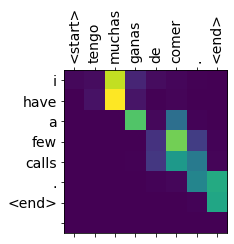

In [115]:
print("Googole translation: I really want to eat.")
translate(u'Tengo muchas ganas de comer.')

In [0]:
from google.colab import files
files.download("/content/machine_translation_with_attention_checkpoint/ckpt-5.data-00001-of-00002")